In [1]:
import numpy as np
import pandas as pd
import chess
import chess.pgn
from ChessFunctions import get_encoded_board, flatten_board
from tqdm import tqdm
import dask
from dask_ml.model_selection import train_test_split as d_train_test_split
from dask_ml.model_selection import GridSearchCV as d_GridSearchCV
import dask.dataframe as dd
import dask.array as da
from dask import delayed
import joblib

In [2]:
GAME_COUNT = 3

In [3]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:51298 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [4]:
f = open('lichess_elite_2020-06.pgn')

In [5]:
%%time 
my_list = []
Y_labels = []
for i in tqdm(range(GAME_COUNT)):
# while True:
    game = chess.pgn.read_game(f)
    if game is None:
        break  # end of file
    my_list.append(game)

100%|██████████| 3/3 [00:00<00:00, 278.44it/s]

CPU times: user 10.5 ms, sys: 2.51 ms, total: 13 ms
Wall time: 13.4 ms


In [6]:
def game_to_df(game):
    #if game.headers['Termination']=='Normal':
    board = game.board() 
    board_state = [flatten_board(board)]
    for move in game.mainline_moves():
        board.push(move)
        board_state = np.row_stack((board_state,flatten_board(board)))
    df = pd.DataFrame(board_state)
    df['gameid'] = game.headers["LichessURL"]
    df['result'] = np.where(game.headers["Result"]=='1-0',1,
                                np.where(game.headers["Result"]=='0-1',-1,0))
    df = df[10:]
    return {'df': df, 'term_type':int(game.headers['Termination']=='Normal')}

In [7]:
%%time
allgame_df = []
game_terminations = []
for game in tqdm(my_list):
    df = delayed(game_to_df)(game)
    allgame_df.append(df['df'])
    game_terminations.append(df['term_type'])
    

100%|██████████| 3/3 [00:00<00:00, 1240.18it/s]

CPU times: user 2.42 ms, sys: 1.82 ms, total: 4.24 ms
Wall time: 4.12 ms


,0,gameid,result
10,rnbqk..rppp.nppp....p......pP......P....P.b......,https://lichess.org/kuUOsOML,0
11,rnbqk..rppp.nppp....p......pP......P....P.P......,https://lichess.org/kuUOsOML,0
12,rnbqk..rpp..nppp....p.....ppP......P....P.P......,https://lichess.org/kuUOsOML,0
13,rnbqk..rpp..nppp....p.....ppP......P..Q.P.P......,https://lichess.org/kuUOsOML,0
14,rnb.k..rppq.nppp....p.....ppP......P..Q.P.P......,https://lichess.org/kuUOsOML,0


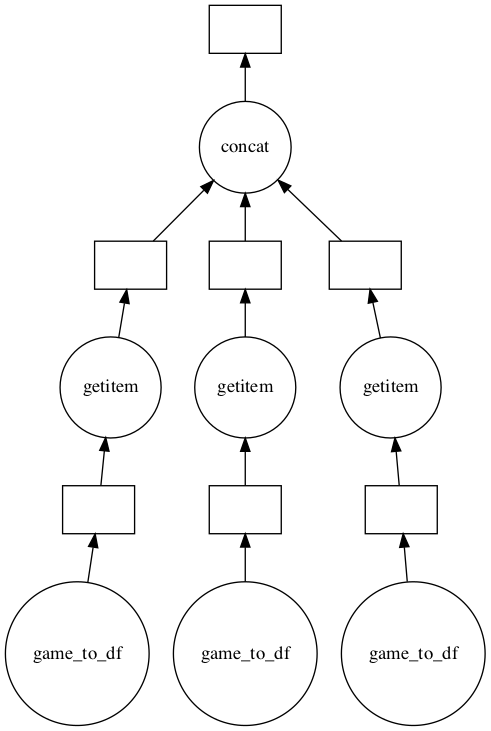

CPU times: user 50.2 ms, sys: 22.9 ms, total: 73.1 ms
Wall time: 1.21 s


In [8]:
%%time
allgame_df_concat = delayed(pd.concat)(allgame_df)
display(allgame_df_concat.compute().head())

if GAME_COUNT < 20:
    display(allgame_df_concat.visualize())

In [9]:
ddf = dd.from_delayed(allgame_df)
ddf['features'] = ddf[0].apply(get_encoded_board,meta=('I'))

In [10]:
def func(df):
    return df.features.apply(np.array, 1)

feature_array = np.concatenate(np.array(ddf.map_partitions(func).compute())).reshape(-1,770)
display(feature_array)
print(feature_array.shape)

array([[ 1,  0,  0, ...,  0, 39, 36],
       [ 1,  0,  0, ...,  0, 36, 36],
       [ 1,  0,  0, ...,  0, 36, 36],
       ...,
       [ 0,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

(209, 770)


def func(df):
    return df.features.apply(pd.Series, 1).stack().reset_index(level=1, drop=True)

In [11]:
X = feature_array
Y_labels = ddf.compute()['result']
print("X: " + str(X.shape))
print("Y: " + str(Y_labels.shape))

X: (209, 770)
Y: (209,)


In [12]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
X_train, X_test, y_train, y_test = d_train_test_split(
    X, Y_labels, train_size = 0.9
    ,random_state=1
)

CPU times: user 6.39 ms, sys: 4.5 ms, total: 10.9 ms
Wall time: 11.3 ms


In [ ]:
X_train.shape, y_train.shape

In [ ]:
%%time
param_grid = {'hidden_layer_sizes':[(50,40,30)]
              ,'tol':[0.00001]
              ,'activation':['relu','logistic']
              ,'max_iter':[2000]
#               ,'learning_rate':['constant','invscaling','adaptive']
              ,'learning_rate_init':[0.0001]
#               ,'early_stopping':[False, True]
             }
mlp = MLPClassifier()
with joblib.parallel_backend('dask'):
    clf = GridSearchCV(mlp, param_grid, n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
print(clf.score(X_test, y_test))
clf.best_estimator_

In [ ]:
from joblib import dump, load
dump(clf, 'FinalModel.joblib')  

In [ ]:
clf = load('filename.joblib') 
clf.classes_